# Predictive Coding

Following Rao&Ballard1999, consider a multi-layered recurrent network of rate neurons, where the first layer $I$ represents the input to the system, and the remaining layers $x_i$ are the representations of that input.
<img src="../../img/predictive-rao-ballard-1.png" title="img1" style="height:80px">

The connections in the above network are not shown, as we will derive them mathematically. The main constraint of R&B is that a good approximation of each representation $x_i$, including the input, can be computed from the previous layer using a matrix multiplication and a nonlinearity (e.g. sigmoid), namely $\hat{x_i} = f(U_i x_{i+1}) + \nu$, where $\nu$ is the possible
<img src="../../img/predictive-rao-ballard-2.png" title="img2" style="height:100px">

As such, the system must evolve to minimize the error of its predictive power. The global squared error is given by

$$E^2
= \sum_i \epsilon_i^2
= \sum_i |r_{i} - \hat{r}_{i}|^2
= \sum_i |r_{i} - f(U_i r_{i+1})|^2
$$

Any given representation $r_i$ has two contributions to the global error: $\epsilon_{i-1}$ determines the efficiency of the representation $r_i$ to predict the previous layer, and $\epsilon_{i}$ the efficiency of being predictable by the next layer. The dynamics of each layer can then be computed as via a gradient descent of the error function

$$\begin{eqnarray}
\tau_i \dot{x}_i
&=& -\frac{1}{2}\partial_{x_i} E^2 \\
&=& -\frac{1}{2}\partial_{x_i} (\epsilon_{i-1}^2 +  \epsilon_{i}^2) \\
&=& U_{i-1}^T \epsilon_{i-1} f'(U_{i-1}x_i) - \epsilon_i \\
&=& U_{i-1}^T (x_{i-1} - f(U_{i-1}x_i)) f'(U_{i-1}x_i) - (r_{i} - f(U_i x_{i+1})) \\
&=& -x_{i} + U_{i-1}^T x_{i-1} f'(U_{i-1}x_i) + f(U_i x_{i+1}) - U_{i-1}^T f(U_{i-1}x_i) f'(U_{i-1}x_i)
\end{eqnarray}$$

For simplicity, choose a linear function $f(x) = x$, then $f'(x) = 1$, and the dynamics equation can be rewritten as

$$\tau_i \dot{x}_i = -x_{i} + U_{i-1}^T x_{i-1} + U_i x_{i+1} - U_{i-1}^T U_{i-1}x_i$$

The terms of the RHS can be identified as leak, forwards-propagated representation, backwards-propagated representation, and self-inhibition. If we introduce the auxiliary inhibitory populations $i_i$, we can now draw the connectivity
<img src="../../img/predictive-rao-ballard-3.png" title="img3" style="height:150px">

Gradient descent can also be used to compute the plasticity rule for optimizing the representation matrix

$$\begin{eqnarray}
\tau_{U_i} \dot{U}_i
&=& -\frac{1}{2}\partial_{U_i} E^2
= -\frac{1}{2}\partial_{U_i} \epsilon_{i}^2 \\
&=& (x_{i} - f(U_{i} x_{i+1})) f'(U_{i}x_{i+1}) x_{i+1}^T \\
&=& x_{i} x_{i+1}^T f'(U_{i}x_{i+1}) - f(U_{i} x_{i+1})x_{i+1}^T f'(U_{i}x_{i+1})
\end{eqnarray}$$

Again, assuming $f(x) = x$, we can simplify the plasitcity rule to
$$\tau_{U_i} \dot{U}_i = x_{i} x_{i+1}^T - U_{i} x_{i+1} x_{i+1}^T$$
It is a form of Hebbian plasticity

**Criticism**:
* Same matrix weights $U_i$ appears 4 times in the design, but plasticity rule only given for the feedback weight.
* Feedforward and Feedback connectivity is symmetric.
* Connectivity $U_i$ is dense.
* The equation for highest layer are different than for the rest, as it does not receive input from above. Thus it does not have a natural leak term. Perhaps a leak term can be extracted by decomposing it from the self-inhibition, but that is only possible if the self-inhibition is at least as strong as the leak would be. Point being, it is not obvious that the equations selected to govern the last layer are consistent with the ones of rate-based neurons.
* The above equations do not take into account synaptic lags

**TODO**:
* Implement exact version of above, see if it really works
* Continue with Bogacz2017
* Add priors from R&B, understand what they do (low priority)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inputLib import genRandomImg

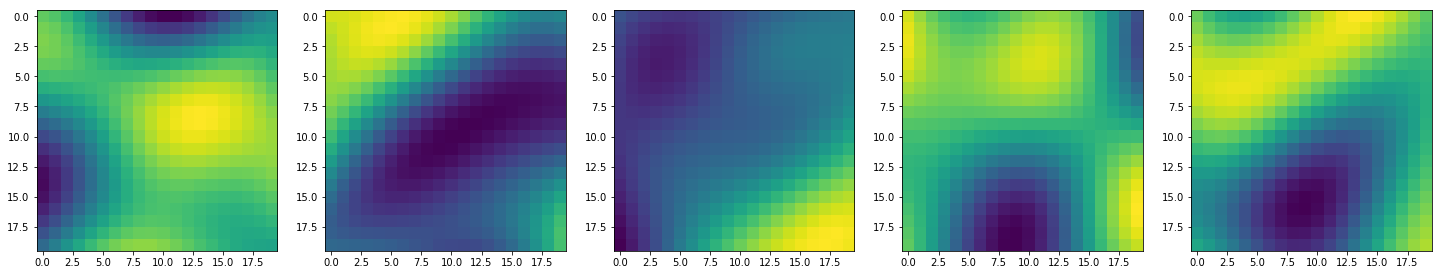

In [2]:
##################################
# Generate some random pictures
##################################
N_IMAGES = 5
NPIX_ROW = 20
NPIX_COL = 20

images = [genRandomImg(NPIX_ROW, NPIX_COL) for i in range(N_IMAGES)]

fig, ax = plt.subplots(ncols=N_IMAGES, figsize=(5*N_IMAGES, 5))
for i in range(N_IMAGES):
    ax[i].imshow(images[i])
plt.show()

## Naive implementation - Deep N-Layer Impl

$$
\begin{eqnarray}
  \tau_{x_1} \dot{x_1} &=& U_1^T (I - U_1 x_1) -x_1 + U_2 x_2 \\
  \tau_{x_i} \dot{x_i} &=& U_i^T (x_{i-1} - U_i x_i) -x_i + U_{i+1} x_{i+1} \\
  \tau_{x_n} \dot{x_n} &=& U_n^T (x_{n-1} - U_n x_n) \\
  \tau_{U_1} \dot{U_1} &=& (I - U_1 x_1) x_1^T \\
  \tau_{U_i} \dot{U_i} &=& (x_{i-1} - U_i x_i) x_i^T
\end{eqnarray}
$$

**Conclusions**:
* **Problem: Degeneration** - higher levels frequently end up being the same

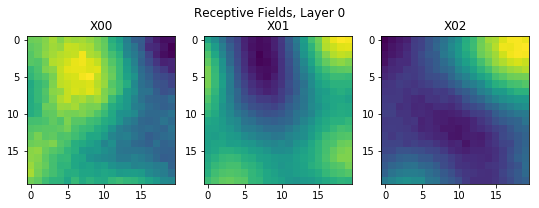

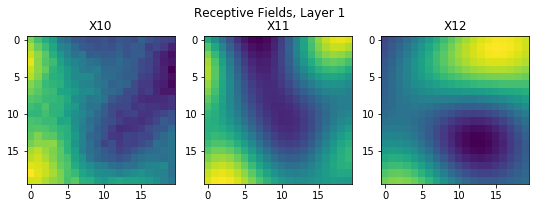

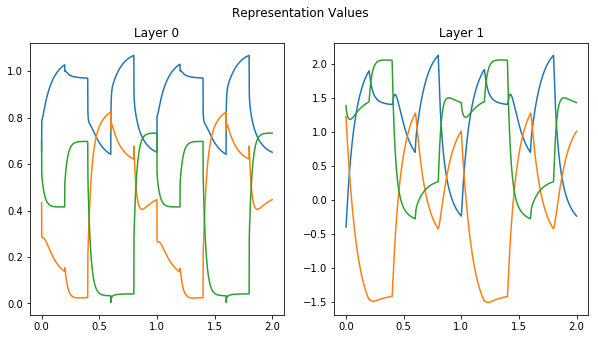

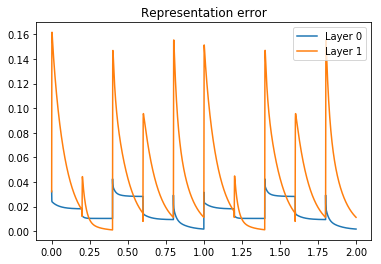

In [141]:
##################################
# Write down update rules
##################################
def update(x, U, I, p, WITH_SP=True):
    N_LAYER = len(x)
    xnew = []
    Unew = []
    zeta_x = p['dt'] / p['tau_x']
    zeta_U = p['dt'] / p['tau_U']
    for i in range(N_LAYER):
        Ieff = I if i == 0 else x[i-1]
        eps = Ieff - U[i].dot(x[i])
        
        # Add feedforward and feedback input input
        RHS_X = U[i].T.dot(eps)
        if i != N_LAYER-1:
            RHS_X += -x[i] + U[i+1].dot(x[i+1]) 
        xnew += [x[i] + zeta_x * RHS_X]
        
        # Synaptic Plasticity
        if WITH_SP:
            RHS_U = np.outer(eps, x[i])
            Unew += [U[i] + zeta_U * RHS_U]
        
    return (xnew, Unew) if WITH_SP else xnew

##################################
# Initialize model
##################################

param = {
    'dt' : 0.0001,
    'tau_x' : 0.001,
    'tau_U' : 0.1,
    "noise_mag" : 0}

N_INP = NPIX_ROW*NPIX_COL
INP_lst = [pic.flatten() for pic in images]
N_IMG = 5

N_LAYER = 2
N_X = [3, 3]
N_IX = [N_INP] + N_X

x = [np.random.uniform(0.9, 1, nx) for nx in N_X] 
U = [np.random.uniform(0, 1, N_IX[i-1]*N_IX[i]).reshape((N_IX[i-1], N_IX[i])) for i in range(1, N_LAYER+1)]
U = [u / np.linalg.norm(u) for u in U]

##################################
# Training
##################################
for iStep in range(200000):
#     if iStep % 10000 == 0:
#         print(iStep)
    idx_I = (iStep // 2000) % N_IMG
    I_this = INP_lst[idx_I]# + param['noise_mag'] * np.random.normal(0, 1, N_INP)
    x, U = update(x, U, I_this, param)
    
##################################
# Testing
##################################
N_STEP_TEST = 20000
times_lst = np.linspace(0, N_STEP_TEST-1, N_STEP_TEST) * param['dt']
x_data = []
err = np.zeros((N_STEP_TEST, N_LAYER))
for iStep in range(N_STEP_TEST):
    idx_I = (iStep // 2000) % N_IMG
    I_this = INP_lst[idx_I] + param['noise_mag'] * np.random.normal(0, 1, N_INP)
    x = update(x, U, I_this, param, WITH_SP=False)
    x_data += [x]
    
    for iLayer in range(N_LAYER):
        Ieff = I_this if iLayer == 0 else x[iLayer-1]
        err[iStep][iLayer] = np.linalg.norm(Ieff - U[iLayer].dot(x[iLayer])) / np.sqrt(len(Ieff))
    
##################################
# Plotting
##################################
def backprop_receptive(U, depth, iLayer, iX):
    return U[iLayer][:,iX] if depth==0 else U[iLayer].dot(backprop_receptive(U, depth-1, iLayer+1, iX))

# Receptive fields
for iLayer in range(N_LAYER):
    fig, ax = plt.subplots(ncols=N_X[iLayer], figsize=(3*N_X[iLayer], 3))
    fig.suptitle("Receptive Fields, Layer "+str(iLayer))
    for iX in range(N_X[iLayer]):
        ax[iX].imshow(backprop_receptive(U, iLayer, 0, iX).reshape((NPIX_ROW, NPIX_COL)))
        ax[iX].set_title("X"+str(iLayer)+str(iX))
    plt.show()

# Representation values
fig, ax = plt.subplots(ncols=N_LAYER, figsize=(5*N_LAYER, 5))
fig.suptitle("Representation Values")
for iLayer in range(N_LAYER):
    xthis = np.array([x[iLayer] for x in x_data])
    ax_this = ax[iLayer] if N_LAYER > 1 else ax    # In matlab ax is not a list if it has only one element :(
    for iX in range(N_X[iLayer]):
        ax_this.plot(times_lst, xthis[:, iX])
        ax_this.set_title("Layer "+str(iLayer))
plt.show()

# Errors
plt.figure()
plt.title("Representation error")
for iLayer in range(N_LAYER):
    plt.plot(times_lst, err[:, iLayer], label="Layer "+str(iLayer))
plt.legend()
plt.show()